# A/B тест задача 1

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
(приложите скрипт с помощью которого анализировали данные, желательно файл .ipynb на python)

Выполняет: Никита Лисоветин (telegram: https://t.me/nikitalisovetin) как базовое тестовое задание в команду продуктовой аналитики в https://ok.ru

# Подключаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
from scipy import stats

# Загружаем данные a/b теста

In [2]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.columns= df.columns.str.lower()
df.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


## Посмотрим на данные

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
len(np.unique(df.user_id))

6324

In [5]:
df.groupby(['user_id', 'variant_name']).sum()

revenue
user_id variant_name         
2       control          0.00
3       control          0.00
        variant          0.00
4       variant          0.00
5       variant          0.00
...                       ...
9996    control          0.00
        variant          6.46
9998    control          0.00
10000   control          0.00
        variant          0.00

[7865 rows x 1 columns]

In [6]:
df_variant = df[df.variant_name == 'variant']
df_control = df[df.variant_name == 'control']

In [7]:
count_variant = len(df_variant)
count_control = len(df_control)

count_variant, count_control

(5016, 4984)

In [8]:
zeroes_variant = len(df_variant[df_variant.revenue == 0.00])
zeroes_control = len(df_control[df_control.revenue == 0.00])

zeroes_variant, zeroes_control

(4944, 4904)

6324 != 7865 != 10000, что означает, что есть пользователи, встречающиеся в таблице несколько раз и по несколько раз в разных группах (control и variant). Нулей очень много. Встает вопрос: "Что делать в этом случае?". Можно ли выкинуть полные дубликаты? Нужно ли для каждого пользователя иметь в виду суммарный доход в control и суммарный доход в variant? Имеет ли смысл смотреть только на тех пользователей, для которых есть запись с variant_name=control и =variant? Можно ли забить на "нули"? Можно ли забить на "user_id"?

Давайте исходить из того, что данные были получены в результате решения следующей задачи:

# Задача
В течение недели в онлайн-магазин заходили пользователи и совершали покупки. В половине сессий показывался один дизайн сайта, в другой половине - другой. Соответственно, одной записе в таблице соответствует одна сессия. Хочется понять какой дизайн оставить

Извлечем из данных максимум/посчитаем разные продуктовые метрики

In [9]:
total_revenue_variant = np.sum(df_variant.revenue)
total_revenue_control = np.sum(df_control.revenue)

total_revenue_variant, total_revenue_control

(351.47, 643.0)

Если оставить нули, то при дальнейшем анализе мы сможем сделать только один вывод - да, почти всегда доход 0. Давайте их уберем. При этом "0", которые могли бы означать, что при одном дизайне пользователи вовсе перестали платить, дадут свой вклад в продуктовые метрики, например, при сравнении "средних доходов по пользователям в variant и control".

Для сравнения доходов так же нужно выкинуть очевидные выбросы

In [10]:
df_positive_variant = df_variant[df_variant.revenue != 0.00]
df_positive_control = df_control[df_control.revenue != 0.00]

<AxesSubplot:xlabel='revenue'>

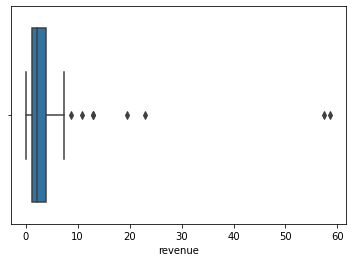

In [11]:
sns.boxplot(df_positive_variant.revenue)

<AxesSubplot:xlabel='revenue'>

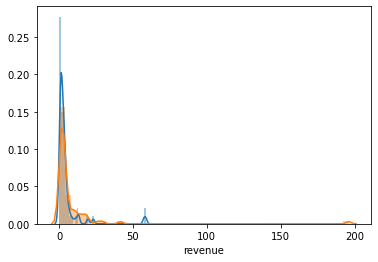

In [12]:
sns.distplot(df_positive_variant.revenue)
sns.distplot(df_positive_control.revenue)

# Посмотрим на хвосты

In [13]:
df.sort_values(by=['revenue']).sort_values(by=['revenue'], ascending=False).reset_index(drop=True).head(20)

,user_id,variant_name,revenue
0,3342,control,196.01
1,2881,variant,58.63
2,7206,variant,57.46
3,6792,control,41.53
4,2166,control,29.32
5,831,control,25.98
6,7356,variant,23.04
7,1053,control,20.07
8,3684,variant,19.47
9,282,control,18.56


In [14]:
df.groupby(['user_id'])[['revenue']].sum().sort_values(by=['revenue'], ascending=False).reset_index().head(20)

,user_id,revenue
0,3342,196.01
1,2881,58.63
2,7206,57.46
3,6792,41.53
4,2166,29.32
5,831,25.98
6,7356,23.04
7,1053,20.07
8,3684,19.47
9,282,18.56


Вывод: наибольший доход был получен в результате сессий разных пользователей. Причем, эти сессии были единственными, когда эти пользователи что-то покупали.

Это соответствует сформулированной задаче, а именно тому, что данные были собраны за 1 неделю.

Выбросы объясняются тем, что дорогие товары/заказы существуют и их иногда покупают/осуществляют разные люди.

# Чистка данных для визуального изучения

In [15]:
min_border = np.percentile(df_positive_variant.revenue, 10)
max_border = np.percentile(df_positive_variant.revenue, 90)
min_border, max_border

(0.6, 8.556999999999997)

In [16]:
df_visual_positive_variant = df_positive_variant[(df_positive_variant['revenue'] > min_border) & (df_positive_variant['revenue'] < max_border)]

<AxesSubplot:xlabel='revenue'>

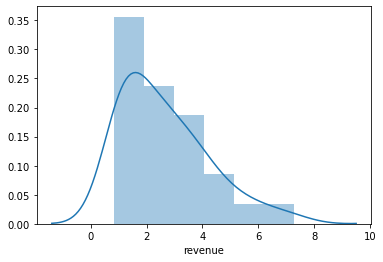

In [17]:
sns.distplot(df_visual_positive_variant.revenue)

<AxesSubplot:xlabel='revenue'>

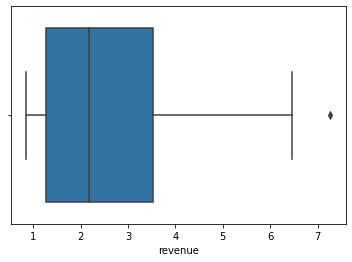

In [18]:
sns.boxplot(x='revenue',
           data=df_visual_positive_variant, orient='h')

### Делаем то же самое для control

In [19]:
min_border = np.percentile(df_positive_control.revenue, 10)
max_border = np.percentile(df_positive_control.revenue, 90)
min_border, max_border

(0.8320000000000001, 17.053)

In [20]:
df_visual_positive_control = df_positive_control[(df_positive_control['revenue'] > min_border) & (df_positive_control['revenue'] < max_border)]

<AxesSubplot:xlabel='revenue'>

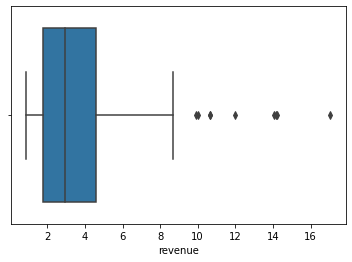

In [21]:
sns.boxplot(x='revenue',
           data=df_visual_positive_control, orient='h')

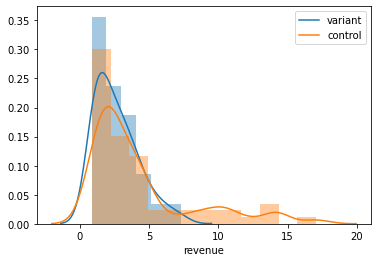

In [22]:
sns.distplot(df_visual_positive_variant.revenue, kde_kws={"label": "variant"})
sns.distplot(df_visual_positive_control.revenue, kde_kws={"label": "control"})

plt.savefig('distplots.png')

## Violin plot

In [23]:
df_violin = pd.concat([df_visual_positive_variant, df_visual_positive_control])
df_violin.head()

,user_id,variant_name,revenue
13,2529,variant,2.15
139,3331,variant,4.27
149,8110,variant,1.75
540,5845,variant,1.26
1119,8175,variant,5.45


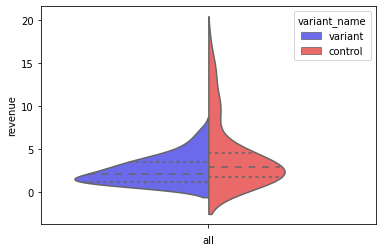

In [24]:
df_violin['all'] = ''
sns.violinplot(x = 'all', y = 'revenue', data = df_violin, inner="quartile", 
               hue = 'variant_name', split = 'True', palette = 'seismic', scale_hue = False, scale = 'area')

plt.savefig('violinplot.png')

## Box plot

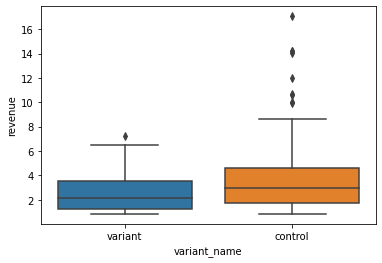

In [25]:
sns.boxplot(x='variant_name', y='revenue', data=df_violin)

plt.savefig('boxplots.png')

# Доход увеличился?

In [26]:
total_positive_revenue_variant = np.sum(df_positive_variant.revenue)
total_positive_revenue_control = np.sum(df_positive_control.revenue)

total_positive_revenue_variant, total_positive_revenue_control

(351.47, 643.0)

In [27]:
count_positive_variant = len(df_positive_variant)
count_positive_control = len(df_positive_control)

count_positive_variant, count_positive_control

(72, 80)

In [28]:
mean_order_variant = total_positive_revenue_variant / count_positive_variant
mean_order_control = total_positive_revenue_control / count_positive_control

mean_order_variant, mean_order_control

(4.881527777777778, 8.0375)

In [29]:
df_positive_variant.head()

,user_id,variant_name,revenue
13,2529,variant,2.15
139,3331,variant,4.27
149,8110,variant,1.75
540,5845,variant,1.26
1119,8175,variant,5.45


In [30]:
gmv_buyer_variant = np.mean(df_positive_variant.groupby(['user_id'])[['revenue']].mean()['revenue'])
gmv_buyer_control = np.mean(df_positive_control.groupby(['user_id'])[['revenue']].mean()['revenue'])

gmv_buyer_variant, gmv_buyer_control

(4.926267605633803, 8.0375)

## Выдвигаем и проверяем статистическую гипотезу

Первоочередная задача бизнеса -- увеличить прибыль. Проверяя новую фичу мы хотим узнать увеличился у нас доход или нет. Поэтому гипотезы формулируются следующим образом:

* H0: доход не изменился, то есть E(revenue(variant)) = E(revenue(control))
* H1: доход увеличился, то есть E(revenue(variant)) > E(revenue(control))
* H1': доход уменьшился, то есть E(revenue(variant)) < E(revenue(control))

Хотим понять можем ли мы принять H0 с уровнем значимости alpha = 0.05?

Сделаем допущение, что выборки независимы. Выборки разного размера, поэтому воспользуемся критерием Манни-Уитни для проверки нулевой гипотезы.

In [31]:
variant = df_positive_variant.revenue.tolist()
control = df_positive_control.revenue.tolist()

In [32]:
stats.mannwhitneyu(variant, control, alternative='greater')

MannwhitneyuResult(statistic=2404.0, pvalue=0.9606931031150104)

In [33]:
stats.mannwhitneyu(variant, control, alternative='less')

MannwhitneyuResult(statistic=2404.0, pvalue=0.039621499053015305)

Значит, нет оснований принимать гипотезу H1': E(revenue(variant)) < E(revenue(control)). Математическое ожидание дохода указанного в записи в таблице уменьшилось. Те, кто совершает покупки, тратят меньше.

# Считаем конверсию

In [34]:
mean_variant_CR = count_positive_variant / count_variant
mean_control_CR = count_positive_control / count_control

mean_variant_CR, mean_control_CR

(0.014354066985645933, 0.016051364365971106)

### Конверсия увеличилась в парной выборке? Выдвигаем и проверяем статистическую гипотезу

Конверсия - одна из основных метрик. Чем выше, тем лучше. Проверяя новую фичу мы хотим узнать увеличилась у нас конверсия или нет. Поэтому гипотезы формулируются следующим образом:

* H0: конверсия не изменилась, то есть E(cr(variant)) = E(cr(control))
* H1: конверсия увеличилась, то есть E(cr(variant)) > E(cr(control))
* H1': конверсия изменилась, то есть E(cr(variant)) != E(cr(control))

Хотим понять можем ли мы принять H0 с уровнем значимости alpha = 0.05?

Сделаем допущение, что выборки независимы. Выборки разного размера, поэтому воспользуемся критерием Манни-Уитни для проверки нулевой гипотезы.

In [35]:
df_variant_payed = df_variant.copy()
df_variant_payed['payed'] = df_variant_payed.apply(lambda row: 0 if row.revenue == 0 else 1, axis = 1)

df_control_payed = df_control.copy()
df_control_payed['payed'] = df_control_payed.apply(lambda row: 0 if row.revenue == 0 else 1, axis = 1)

In [36]:
variant_CR = df_variant_payed.payed.tolist()
control_CR = df_control_payed.payed.tolist()

In [37]:
stats.mannwhitneyu(variant_CR, control_CR, alternative='greater')

MannwhitneyuResult(statistic=12478656.0, pvalue=0.7560381329540834)

In [38]:
stats.mannwhitneyu(variant_CR, control_CR, alternative='two-sided')

MannwhitneyuResult(statistic=12478656.0, pvalue=0.48794424192486574)

Значит, нет оснований отклонять гипотезу H0: E(revenue(variant)) = E(revenue(control)). Математическое ожидание конверсии не изменилось. Пользователи совершают покупки с одинаковой периодичностью вне зависимости от дизайна сайта.

# Рассмотрим парные выборки - пользователей, которые были в обеих группах

In [39]:
users_paired = list(set(df_variant.user_id.tolist()) & set(df_control.user_id.tolist()))

count_users_paired = len(users_paired)
count_users_paired

1541

In [40]:
df_paired = df[df.user_id.isin(users_paired)]

## Как изменился доход?

In [41]:
df_order = pd.concat([df_positive_variant, df_positive_control])

In [42]:
indexes_order_paired = df_order.user_id.isin(users_paired)

In [43]:
df_paired_order = df_order[indexes_order_paired].sort_values(by=['user_id']).reset_index(drop=True)

df_paired_order.head()

,user_id,variant_name,revenue
0,403,variant,1.99
1,618,control,2.19
2,701,control,17.08
3,702,variant,2.92
4,828,variant,0.60


In [44]:
df_paired_variant_order = df_paired_order[df_paired_order.variant_name == 'variant']
df_paired_control_order = df_paired_order[df_paired_order.variant_name == 'control']

count_paired_variant_order = len(df_paired_variant_order)
count_paired_control_order = len(df_paired_control_order)

count_paired_variant_order, count_paired_control_order

(29, 26)

In [45]:
df_paired_mean_order = df_paired_order.groupby(['user_id', 'variant_name'])[['revenue']].mean().reset_index()
df_paired_mean_order.head()

,user_id,variant_name,revenue
0,403,variant,1.99
1,618,control,2.19
2,701,control,17.08
3,702,variant,2.92
4,828,variant,0.60


In [46]:
df_variant_mean_order = df_paired_mean_order[df_paired_mean_order['variant_name'] == 'variant']
df_control_mean_order = df_paired_mean_order[df_paired_mean_order['variant_name'] == 'control']

count_paired_variant_mean_order = len(df_variant_mean_order)
count_paired_control_mean_order = len(df_control_mean_order)

count_paired_variant_mean_order, count_paired_control_mean_order

(29, 26)

In [47]:
(count_paired_variant_order, count_paired_control_order) == (count_paired_variant_mean_order, count_paired_control_mean_order)

True

Это равенство означает, что все, кто сделал заказ в группе, сделал ровно 1 заказ в этой группе

### Изучим визуально

<AxesSubplot:xlabel='revenue'>

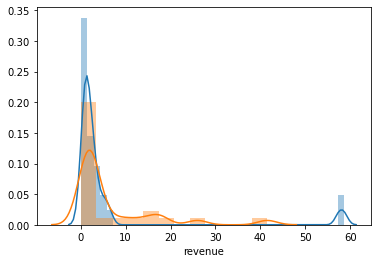

In [48]:
sns.distplot(df_paired_variant_order.revenue)
sns.distplot(df_paired_control_order.revenue)

### Уберем выбросы

In [49]:
min_border = np.percentile(df_paired_variant_order.revenue, 10)
max_border = np.percentile(df_paired_variant_order.revenue, 90)
min_border, max_border

(0.596, 5.651999999999999)

In [50]:
df_visual_paired_variant_order = df_paired_variant_order[(df_paired_variant_order['revenue'] > min_border) & (df_paired_variant_order['revenue'] < max_border)]

<AxesSubplot:xlabel='revenue'>

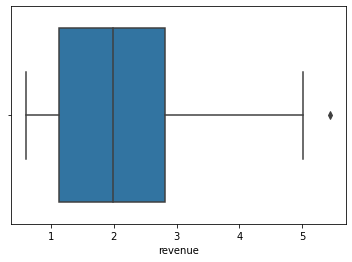

In [51]:
sns.boxplot(x='revenue',
           data=df_visual_paired_variant_order, orient='h')

In [52]:
min_border = np.percentile(df_paired_control_order.revenue, 10)
max_border = np.percentile(df_paired_control_order.revenue, 90)
min_border, max_border

(1.25, 17.475)

In [53]:
df_visual_paired_control_order = df_paired_control_order[(df_paired_control_order['revenue'] > min_border) & (df_paired_control_order['revenue'] < max_border)]

<AxesSubplot:xlabel='revenue'>

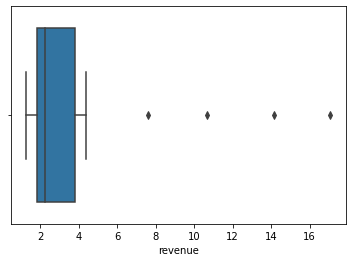

In [54]:
sns.boxplot(x='revenue',
           data=df_visual_paired_control_order, orient='h')

### Разные графики

<AxesSubplot:xlabel='revenue'>

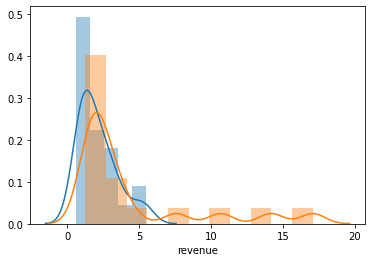

In [55]:
sns.distplot(df_visual_paired_variant_order.revenue)
sns.distplot(df_visual_paired_control_order.revenue)

<AxesSubplot:xlabel='all', ylabel='revenue'>

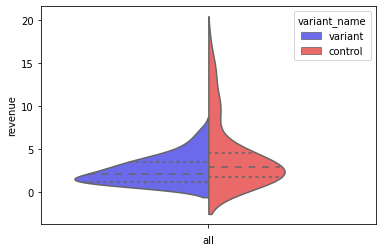

In [56]:
df_paired_violin = pd.concat([df_visual_paired_variant_order, df_visual_paired_control_order])

df_paired_violin['all'] = ''
sns.violinplot(x = 'all', y = 'revenue', data = df_violin, inner="quartile", 
               hue = 'variant_name', split = 'True', palette = 'seismic', scale_hue = False, scale = 'area')

<AxesSubplot:xlabel='variant_name', ylabel='revenue'>

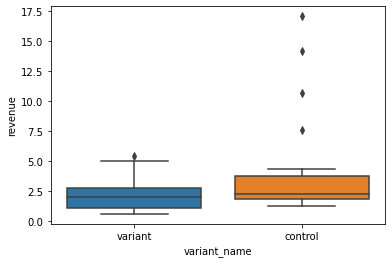

In [57]:
sns.boxplot(x='variant_name', y='revenue', data=df_paired_violin)

Выбросы будто через равные промежутки

In [58]:
df_visual_paired_control_order[df_visual_paired_control_order['revenue'] > 5]

,user_id,variant_name,revenue
2,701,control,17.08
26,5205,control,14.17
29,5769,control,10.67
34,6492,control,7.58


Не через равные, но через примерно 3. Возможно, этому есть объяснение - нужно смотреть на конкретные покупки и тогда можно будет ответить на вопрос как так получилось.

### Числа

In [59]:
np.sum(df_variant_mean_order.revenue), np.sum(df_control_mean_order.revenue)

(172.15000000000003, 172.44)

In [60]:
mean_paired_order_variant = np.mean(df_paired[(df_paired['variant_name'] == 'variant') & (df_paired['revenue'] != 0)].revenue)
mean_paired_order_control = np.mean(df_paired[(df_paired['variant_name'] == 'control') & (df_paired['revenue'] != 0)].revenue)

mean_paired_order_variant, mean_paired_order_control

(5.936206896551726, 6.632307692307692)

In [61]:
len(df_variant_mean_order), len(df_control_mean_order)

(29, 26)

In [62]:
gmv_buyer_paired_variant = np.sum(df_variant_mean_order.revenue) / len(df_variant_mean_order)
gmv_buyer_paired_control = np.sum(df_control_mean_order.revenue) / len(df_control_mean_order)

gmv_buyer_paired_variant, gmv_buyer_paired_control

(5.936206896551726, 6.632307692307692)

### Доход увеличился? Выдвигаем и проверяем статистическую гипотезу

Доход на пользователя - одна из основных метрик. Чем выше, тем лучше. Проверяя новую фичу мы хотим узнать увеличилась ли она. Поэтому гипотезы формулируются следующим образом:

* H0: доход не изменился, то есть E(revenue(variant)) = E(revenue(control))
* H1: доход увеличился, то есть E(revenue(variant)) > E(revenue(control))

Хотим понять можем ли мы принять H0 с уровнем значимости alpha = 0.05?

Сделаем допущение, что выборки независимы. Выборки разного размера, поэтому воспользуемся критерием Манни-Уитни для проверки нулевой гипотезы.

In [63]:
revenue_variant = df_variant_mean_order.revenue.tolist()
revenue_control = df_control_mean_order.revenue.tolist()

In [64]:
stats.mannwhitneyu(revenue_variant, revenue_control, alternative='greater')

MannwhitneyuResult(statistic=281.0, pvalue=0.9482022368607665)

#### Изменился?

In [65]:
stats.mannwhitneyu(revenue_variant, revenue_control, alternative='two-sided')

MannwhitneyuResult(statistic=281.0, pvalue=0.10722333697121259)

p-value >> alpha = 0.05 оба раза, значит, нет оснований отклонять гипотезу H0. Конкретные пользователи, которые видели и тот дизайн, и другой, тратят одинаково вне зависимости от того, какой дизайн они сейчас видят

## Как изменилась конверсия по пользователям?

In [66]:
df_paired_cr = df_paired.copy()
df_paired_cr['payed'] = df_paired_cr.apply(lambda row: 0 if row.revenue == 0 else 1, axis = 1)

In [67]:
df_paired_mean_cr = df_paired_cr.groupby(['user_id', 'variant_name'])[['payed']].mean().reset_index()
df_paired_mean_cr.head()

,user_id,variant_name,payed
0,3,control,0.0
1,3,variant,0.0
2,10,control,0.0
3,10,variant,0.0
4,18,control,0.0


In [68]:
df_variant_mean_cr = df_paired_mean_cr[df_paired_mean_cr['variant_name'] == 'variant']
df_control_mean_cr = df_paired_mean_cr[df_paired_mean_cr['variant_name'] == 'control']

In [69]:
count_paired_variant = len(df_variant_mean_cr)
count_paired_control = len(df_control_mean_cr)

count_paired_variant, count_paired_control

(1541, 1541)

In [70]:
count_paired_variant_order = len(df_variant_mean_cr[df_variant_mean_cr['payed'] != 0])
count_paired_control_order = len(df_control_mean_cr[df_control_mean_cr['payed'] != 0])

count_paired_variant_order, count_paired_control_order

(29, 26)

## Конверсия

In [71]:
mean_paired_variant_CR = count_paired_variant_order / count_paired_variant
mean_paired_control_CR = count_paired_control_order / count_paired_control

mean_paired_variant_CR, mean_paired_control_CR

(0.01881894873458793, 0.016872160934458143)

In [72]:
mean_paired_variant_CR_user = np.mean(df_variant_mean_cr.payed)
mean_paired_control_CR_user = np.mean(df_control_mean_cr.payed)

mean_paired_variant_CR_user, mean_paired_control_CR_user

(0.014600908500973394, 0.010707332900713823)

### Конверсия увеличилась в парной выборке? Выдвигаем и проверяем статистическую гипотезу

Конверсия - одна из основных метрик. Чем выше, тем лучше. Проверяя новую фичу мы хотим узнать увеличилась у нас конверсия или нет. Поэтому гипотезы формулируются следующим образом:

* H0: конверсия не изменилась, то есть E(cr(variant)) = E(cr(control))
* H1: конверсия увеличилась, то есть E(cr(variant)) > E(cr(control))
* H1': конверсия изменилась, то есть E(cr(variant)) != E(cr(control))

Хотим понять можем ли мы принять H0 с уровнем значимости alpha = 0.05?

Воспользуемся критерием Вилкоксона для парных выборок.

In [73]:
cr_variant = df_variant_mean_cr.payed.tolist()
cr_control = df_control_mean_cr.payed.tolist()

In [74]:
stats.wilcoxon(cr_variant, cr_control, alternative='greater')

WilcoxonResult(statistic=876.5, pvalue=0.11914133927733717)

In [75]:
stats.wilcoxon(cr_variant, cr_control, alternative='two-sided')

WilcoxonResult(statistic=608.5, pvalue=0.23828267855467433)

p-value > alpha = 0.05 оба раза, поэтому нет оснований отклонять гипотезу H0. Конкретный пользователь одинаково покупает или не покупает при разном дизайне сайта.

# Соберем все вместе с помощью Excel

В файле result.xlsx собраны графики, числовые значения и решения о значимости.

Чтобы открыть скриншот таблицы, запустите следующий абзац:

In [76]:
from PIL import Image                                                                                
img = Image.open('result.png')
img.show() 

# Промежуточный вывод

В рамках сформулированной выше задачи сделаем промежуточный вывод из данных:

В тестовой группе выявлены значимое падение по многим метрикам: общий доход, средняя сумма заказа и средняя сумма заказа пользователя на 38-45%.

При этом общее число заказов и конверсия сессии в заказ не изменились значимо.

===

Парная выборка, составленная из исходных сырых данных, не показала значимой разницы между метриками. Требуется больше данных для принятия статистически верного решения (сейчас высока вероятность ошибки второго рода).

===

Разница в метриках объясняется наличием множественных выбросов в контрольной группе. Крупные заказы изредка совершают при обычном дизайне, но не совершают при новом.

#### Как так получается, что люди совершают дорогие покупки в control?

# Изучим хвосты внимательнее

In [77]:
count_top = len(df[df.revenue > 8])

count_top

27

In [78]:
count_top / len(df[df.revenue > 0])

0.17763157894736842

In [79]:
top_user_ids = df[df.revenue > 8]['user_id'].tolist()

In [80]:
df_top = df[df.user_id.isin(top_user_ids)]

In [81]:
df_top.sort_values(by=['user_id']).reset_index(drop=True)

,user_id,variant_name,revenue
0,282,control,0.00
1,282,control,18.56
2,701,control,0.00
3,701,variant,0.00
4,701,control,17.08
5,831,control,25.98
6,831,variant,0.00
7,831,control,0.00
8,1053,control,0.00
9,1053,control,0.00


In [82]:
df_top.groupby(['user_id'])[['revenue']].count()

,revenue
user_id,
282,2
701,3
831,3
1053,4
1773,1
1788,1
1973,1
2059,1
2166,2


In [83]:
df_top_count = df_top.groupby(['user_id'])[['revenue']].count()

In [84]:
np.mean(df_top_count['revenue']), np.percentile(df_top_count['revenue'], 25), np.percentile(df_top_count['revenue'], 50), np.percentile(df_top_count['revenue'], 75)

(1.9259259259259258, 1.0, 2.0, 3.0)

#### Как много раз зашли люди, совершившие дорогой заказ?

In [85]:
df_count = df.copy()
df_count = df_count.groupby(['user_id'])[['revenue']].count()
np.mean(df_count['revenue']), np.percentile(df_count['revenue'], 25), np.percentile(df_count['revenue'], 50), np.percentile(df_count['revenue'], 75)

(1.5812776723592663, 1.0, 1.0, 2.0)

#### Как много раз зашли люди, совершившие заказ?

In [86]:
df_count_order = df.copy()
df_count_order = df_count_order.groupby(['user_id'])[['revenue']].agg(['sum', 'count'])
df_count_order = df_count_order[df_count_order['revenue']['sum'] != 0]
np.mean(df_count_order['revenue']['count']), np.percentile(df_count_order['revenue']['count'], 25), np.percentile(df_count_order['revenue']['count'], 50), np.percentile(df_count_order['revenue']['count'], 75)

(2.0533333333333332, 1.0, 2.0, 3.0)

In [87]:
len(df_top_count)

27

In [88]:
len(df_top_count[df_top_count['revenue'] > 1])

14

In [89]:
count_top_control = len(df[(df.revenue > 8) & (df.variant_name == 'control')])

count_top_control

19

In [90]:
count_top_control / count_top

0.7037037037037037

In [91]:
np.sum(df[(df.revenue > 8) & (df.variant_name == 'control')]['revenue']) / np.sum(df[df.revenue > 8]['revenue'])

0.7086574834058954

#### Какую долю от всех составляют дорогие заказы по количеству заказов?

In [92]:
count_top / len(df[df.revenue > 0])

0.17763157894736842

#### Какую долю от всех составляют дорогие заказы по сумме дохода?

In [93]:
np.sum(df[df.revenue > 8]['revenue']) / np.sum(df[df.revenue > 0]['revenue'])

0.7044455840799622

# Что, если убрать хвосты?

In [94]:
df_basic_variant = df[(df.variant_name == 'variant') & (df.revenue > 0) & (df.revenue < 8)]
df_basic_control = df[(df.variant_name == 'control') & (df.revenue > 0) & (df.revenue < 8)]

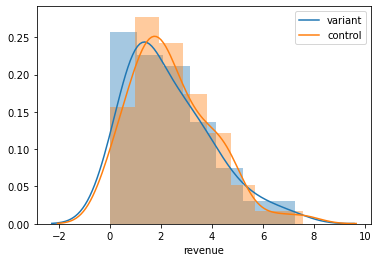

In [95]:
sns.distplot(df_basic_variant.revenue, kde_kws={"label": "variant"})
sns.distplot(df_basic_control.revenue, kde_kws={"label": "control"})

plt.savefig('distplots_basic.png')

In [96]:
stats.mannwhitneyu(df_basic_variant.revenue.tolist(), df_basic_control.revenue.tolist(), alternative='two-sided')

MannwhitneyuResult(statistic=1829.0, pvalue=0.544957365149969)

p-value > alpha = 0.05, значит, нет оснований отклонять гипотезу H0 о том, что математическое ожидание дохода не изменилось. Пользователи тратят одинаково при любом дизайне, если покупка на сумму 0 < revenue < 8.

# Окончательный вывод

## Задача

В течение недели в онлайн-магазин заходили пользователи и совершали покупки. В половине сессий показывался один дизайн сайта, в другой половине - другой. Соответственно, одной записе в таблице соответствует одна сессия. Хочется извлечь максимум из данных, выдвинуть гипотезы и дать рекомендации по дальнейшей работе

## Результат

На изображении results.png перечислены основные метрики и графики.

Доходы в тестовой и контрольной выборках в заказах с revenue до 8.0 распределяются одинаково и не отличаются значимо. Но за счет заказов с revenue больше 8.0, которые составляют по количеству 17.76% от всех заказов и 70.44% по сумме дохода, контрольная выборка показала гораздо лучшие метрики (на нее пришлось 70.37% дорогих заказов по количеству и 70.86% по сумме дохода; разные люди несколько раз заходят на сайт и совершают дорогую покупку именно на контрольном дизайне).

В тестовой группе выявлены значимое падение по многим метрикам: общий доход, средняя сумма заказа и средняя сумма заказа пользователя на 38-45%.

При этом общее число заказов и конверсия сессии в заказ не изменились значимо.

===

Парная выборка (то есть по пользователям, видевших оба дизайна), составленная из исходных сырых данных, не показала значимой разницы между метриками. Требуется больше данных для принятия статистически верного решения (сейчас высока вероятность ошибки второго рода).


# Что дальше?

(Disclaimer: в рамках тестовой задачи мы не знаем какая задача именно решалась и как ставился a/b тест, но мы можем предположить разные варианты и предложить дальнейшие действия)

Мы поняли, что почему-то **дорогие заказы совершают в контрольном дизайне. И они очень важны.** Теперь главные вопросы: 
* Почему?
* Как мы можем еще помочь пользователям?
* Как нам дальше развивать продукт и увеличивать прибыль?

Чтобы ответить на них нужно понять (под пунктами примеры ситуаций):

1. Что именно отличается в тестовом и контрольном дизайнах и как это может логически влиять на совершение/не совершение дорогого заказа + сравнить с конкурентами с похожими товарами
    * Дорогим пользователям важно пообщаться с оператором в чате (тот самый, который "Я тут, напишите мне, я Вам помогу"), который пропал из тестового дизайна
    * Некоторая ценность важна для совершения дорогой покупки (например, написано, что "гарантия - MUST HAVE", а это телефон за 60 тысяч рублей и она в придачу на 3 года; или доставка за 1 день), которая не демонстрируется или стала незаметна в тестовом дизайне
    * Просто в "рекомендациях" не всплывают дорогие товары и, соответственно, потенциальный покупатель не узнает о них или о том, что вообще такое можно купить на сайте
    * "Фейковая" скидка на товар или другой бонус (wildberries вот постоянно меняет цены и, возможно, в тестовом дизайне он бы решил сразу показать минимальную цену и получил бы такие данные)
    * Добротный логотип, внушающий доверие
    * Огромная кнопка "купить в 1 клик"
    * Заметные логотипы VISA, MasterCard, показывающие возможность быстро сделать покупку
    * 3D-модель товара
    * В тестовом дизайне появилась возможность сортировать по возрастанию цены (или даже по-дефолту, или "ограничить цену от и до"), все пользователи начали сразу сортировать и, соответственно, просто тупо перестали доходить до дорогих товаров
    * Что-то отвалилось на одной из платформ (десктоп, андроид, айос) и тупо не успевает загрузиться
    * Для дорогих товаров картинки настолько крутые, что в тестовом дизайне загружаться стали слишком долго
    * В тестовом дизайне важный элемент блокируется адблокером
1. Поведение пользователей, желающих совершить дорогой заказ, и как контрольный дизайн им помогает
    * Ищут ли они специально этот дорогой товар или случайно натыкаются и сразу покупают?
    * Как долго принимают решение? Находят утром и покупают вечером или ждут неделю?
    * Гложат ли их сомнения, смотрят ли аналоги, сколько времени проводят на сайте, звонят ли по горячей линии, что спрашивают в чате?
1. Что объединяет этих пользователей?
    * Это "родители младенцев"?
    * Они добавляют очень много товаров в "понравившиеся"/"сравнение"
    * Они заходят на наш сайт лишь чтобы проверить цену на дорогие товары?
    * Они покупают только дорогие товары? (соответственно, тогда, возможно, все дешевые просто можно убрать и заточить продукт под дорогие)
1. Что объединяет эти товары? (возможно, что они одного типа или похожих)
    * Товары для профессиональных спортсменов
    * Товары для дачников
    * Это реально классные качественные товары
    * Это аксессуары для техники Apple
1. Что отличает эти товары от остальных на сайте?
    * У них большое красивое описание
    * Товары от классных брендов
    * В тестовом дизайне нужно нажать отдельную кнопку, чтобы увидеть дорогие товары
    
## Несколько задач для аналитиков данных

1. Посмотреть на просмотры дорогих товаров. Менятся ли конверсия на дорогих товарах в зависимости от дизайна?
1. Посмотреть на общее поведение пользователей, совершивших дорогой заказ или которые могли его совершить: искали ли они именно его, были ли их сессии подряд (возможно, что на сайте баг и они специально обновляли страницу) или с перерывом (какой это перерыв? утро-вечер, 2 дня, неделя?) (сколько времени проходит от просмотра до покупки?), на какой платформе, куда тыкали на сайте
1. Изучить пользователей, совершивших дорогой заказ. Составить их портрет. Отличается ли он от других пользователей?
1. Продлить или расширить текущий a/b тест для статистически значимого анализа парной выборки: меняется ли доход от конкретного пользователя, когда он видит контрольный или тестовый дизайн?
1. Изучить дорогие товары, которые купили эти пользователи: что их объединяет, что отличает?

# Вердикт

Хоть тестовое решение и показало значительное снижение дохода, a/b тест был важным: он показал, что какая-то конкретная вещь влияет на 20% пользователей, совершающих дорогие покупки с revenue > 8.0 и делающих 70% суммарного дохода. При этом никак не влияет на 80% пользователей, совершающих покупки с revenue <= 8.0.

В зависимости от того, что именно было сделано, возможно, что целесообразно раскатить фичу на товары с revenue <= 8.0 (если это экономит что-либо: железо (если меньше данных хранить и считать нужно или скорость выдачи понижаем), работу операторов чатов, работу фотографов, редакторов), а для товаров с revenue > 8.0 усилить сильные стороны текущего решения (возможно, что даже просто начать продавать только эти товары или демонстрируя на главной только их). Дополнительная аналитика поможет лучше понять, кто эти пользователи и какие ценности им важны, какие новые идеи (а не изменение текущих решений) могут помочь людям, совершающим дорогие заказы и, соответственно, увеличить наш доход.

Ну, и, вне зависимости от деталей задачи, если экономия от введения фичи больше падения дохода, то, конечно, тоже целесообразно ее продолжать раскатывать постепенно (если a/b тест был на 1%, то нужно дальше на 10%, 50%, 100% и на всех потом раскатить, если результаты будут подтверждаться).

Если речь идет о кратковременной акции (день холостяка) или сезонном предложении (маски от коронавируса), то нужно переосмыслить решение перед следующим разом, потому что идея может быть хорошей, но мы только потеряли важных для нас пользователей.